In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [17]:
# load the ribbon data
# parameters
efield = 0.0
nk = 801
nwann = 56
nfilling_per_uc = 36
ribbon_width = 25
eigvals_all, ks = [], []
eigvecs_sel = []

fermilevel_shift = 0.06

with h5py.File(f"./data/ribbon_efield{efield}.hdf5", 'r') as f:
    bands_chosen = f["bands_chosen"][()]
    for ik in np.arange(nk):
        ks.append(f[f"ik{ik}/k"][()])
        eigvals_all.append(f[f"ik{ik}/eigvals"][()])
        eigvecs_sel.append(f[f"ik{ik}/eigvecs_bands_selected"][()])
    
ks = np.array(ks)
eigvals_all = np.array(eigvals_all)  # (nk, nbands_tot)
eigvecs_sel = np.array(eigvecs_sel)  # (nk, norb, bands_selected)

# get the projection of each eigenvec onto the first and last unit cell
psi2 = eigvecs_sel * eigvecs_sel.conj()

# the indices of the orbitals of the initial and the final cell
celli_indx = np.arange(nwann)
cellf_indx = np.arange(nwann*(ribbon_width-1), nwann*ribbon_width)
proj_celli = np.sum(psi2[:,celli_indx,:], axis=1)
proj_cellf = np.sum(psi2[:,cellf_indx,:], axis=1)
proj_bulk = np.sum(psi2, axis=1) - proj_celli - proj_cellf

# the indices of the orbitals of the initial and the final cell
celli_up_indx = np.arange(0,nwann,2)
celli_dn_indx = np.arange(1,nwann,2)
proj_celli_up = np.sum(psi2[:,celli_up_indx,:], axis=1)
proj_celli_dn = np.sum(psi2[:,celli_dn_indx,:], axis=1)

In [27]:
# find the Fermi level
def find_efermi(eigvals_all, nelec_tot):
    eigvals_all_sorted = np.sort(eigvals_all.flatten())
    vbm = eigvals_all_sorted[nelec_tot - 1]
    cbm = eigvals_all_sorted[nelec_tot]
    return 0.5 * (vbm + cbm)


nelec_tot = nfilling_per_uc * ribbon_width * nk
efermi = find_efermi(eigvals_all, nelec_tot) + fermilevel_shift

# reference: bulk efermi = 2.382502 (see "generate_pdos.ipynb in old repo")
print(f"ribbon efermi = {efermi}")

# shift all the eigenvales by efermi
eigvals_all -= efermi

ribbon efermi = 2.3808294043674953


In [37]:
eigvals_all[10,850:950]

array([-1.61650023, -1.6094604 , -1.58991233, -1.58075761, -1.5739668 ,
       -1.568753  , -1.54057641, -1.53903746, -1.5276616 , -1.52440227,
       -1.49862603, -1.49272155, -1.48421375, -1.47410564, -1.45754567,
       -1.4491896 , -1.43774348, -1.42698738, -1.41540202, -1.40727184,
       -1.3926422 , -1.38389026, -1.37345017, -1.36608697, -1.35150145,
       -1.34374838, -1.33455342, -1.32687866, -1.31511489, -1.30719444,
       -1.30020784, -1.29218352, -1.2839955 , -1.27614817, -1.27153116,
       -1.26437105, -1.25910267, -1.25229689, -1.2501957 , -1.24650453,
       -1.24065008, -1.23611481, -1.22876218, -1.22610289, -1.22331288,
       -1.19757676, -1.1461749 , -1.11927082, -0.39799749, -0.38422206,
        0.67793128,  0.73819793,  1.04591605,  1.07960099,  1.86427447,
        1.86430867,  1.86450286,  1.86453194,  1.86728933,  1.86737922,
        1.86759842,  1.86761645,  1.87214301,  1.87236959,  1.87263057,
        1.87266769,  1.87873395,  1.87913791,  1.87944484,  1.87

(-0.2, 0.2)

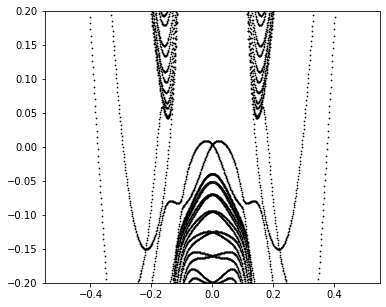

In [30]:
# just plot the dispersion
fig, ax = plt.subplots(1,1,figsize=(6,5))
for ibb, ib in enumerate(bands_chosen):
    ax.scatter(ks[:,0], eigvals_all[:,ib],c='k', s=0.5)

ax.set_ylim([-0.2, 0.2])

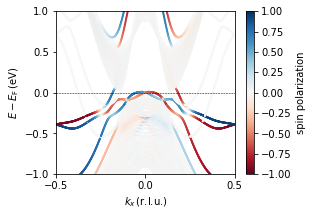

In [38]:
# now plot the bands structure for the ribbon,
# with the colors indicating how much the states are projected onto the edges
fig, ax = plt.subplots(1,1,figsize=(4,3))

proj_celli_spin = proj_celli_up - proj_celli_dn

for ibb, ib in enumerate(bands_chosen):
    # plot the bands with the color indicating the proj_celli
    ax.scatter(ks[:,0], eigvals_all[:,ib], c=proj_celli_spin[:,ibb].real, cmap='RdBu', s=1, vmax=1, vmin=-1)


ax.set_xlim(ks.min(), ks.max())
ax.set_xticks([ks.min(), 0, ks.max()])
ax.set_xlabel(r"$k_x\,$(r.l.u.)")

ax.set_ylim(-1, 1)
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.set_ylabel(r"$E-E_{\mathrm{F}}\,$(eV)")

ax.axhline(0, color='k', lw=0.5, ls='--')

# customize the colorbar    
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(-1, 1))
sm.set_array([])
fig.colorbar(sm, ax=ax, label="spin polarization")
fig.savefig("./figures/ribbon_e0.png", bbox_inches='tight', dpi=360)

/Users/heather/opt/anaconda3/envs/pyqmc_dev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:4322: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


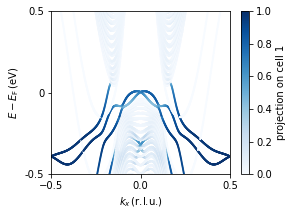

In [4]:
# now plot the bands structure for the ribbon,
# with the colors indicating how much the states are projected onto the edges
fig, ax = plt.subplots(1,1,figsize=(4,3))

for ibb, ib in enumerate(bands_chosen):
    # plot the bands with the color indicating the proj_celli
    ax.scatter(ks[:,0], eigvals_all[:,ib], c=proj_celli[:,ibb], cmap='Blues', s=1, vmax=1, vmin=0)


ax.set_xlim(ks.min(), ks.max())
ax.set_xticks([ks.min(), 0, ks.max()])
ax.set_xlabel(r"$k_x\,$(r.l.u.)")

ax.set_ylim(-0.5, 0.5)
ax.set_yticks([-0.5, 0, 0.5])
ax.set_yticklabels(["-0.5", "0", "0.5"])
ax.set_ylabel(r"$E-E_{\mathrm{F}}\,$(eV)")

# customize the colorbar    
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(0, 1))
sm.set_array([])
fig.colorbar(sm, ax=ax, label="projection on cell 1")



In [5]:
# A better visualization would be the spectral function
# A(k, omega) = sum_n |<n|c_k>|^2 * delta(omega - (E_n - E_0))  

def lorentzian(omega_list, efermi, eigvals_k, proj_k, broadening=2e-3):
    delta_omega_k = 1/(np.pi*broadening) * broadening / ((omega_list - (eigvals_k[:,np.newaxis] - efermi))**2 + broadening**2)
    return np.einsum('ij,i...->j...', delta_omega_k, proj_k)

def proj_spectral_function(eigvals, proj, klist, ewindow, epsilon = 1e-3):
    # compute the projected spectral function
    e_grid = np.arange(ewindow[0], ewindow[1], epsilon)

    # now compute the spectral function on the grid of given k points and e_grid
    A = np.zeros((len(klist), len(e_grid)))
    for ik, k in enumerate(klist):
        A[ik] = lorentzian(e_grid, 0, eigvals[ik,:], proj[ik,:], broadening=epsilon)
    return A, e_grid

# Compute the projected spectral function
ewindow = [-2.0, 2.0]
eigvals_sel = eigvals_all[:,bands_chosen]
A_bulk, e_grid = proj_spectral_function(eigvals_sel, proj_bulk, ks, ewindow)
A_celli, e_grid = proj_spectral_function(eigvals_sel, proj_celli, ks, ewindow)  
A_cellf, e_grid = proj_spectral_function(eigvals_sel, proj_cellf, ks, ewindow)

/var/folders/s4/8x9zf7mn76x05kgp2knhz_k00000gn/T/ipykernel_8319/2532780800.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  A[ik] = lorentzian(e_grid, 0, eigvals[ik,:], proj[ik,:], broadening=epsilon)


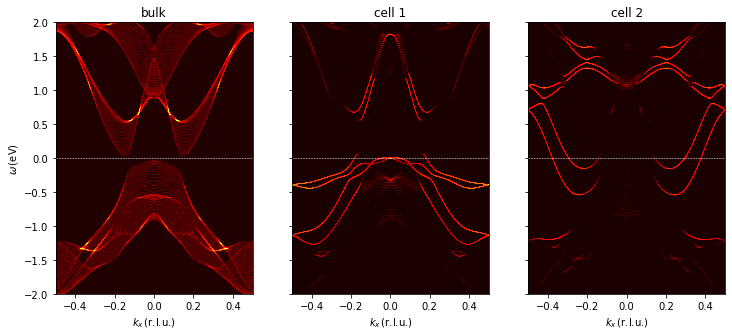

In [6]:
# plot the spectral function as a countour plot

fig, ax = plt.subplots(1,3,figsize=(4*3,5), sharey=True)
title_list = ["bulk", "cell 1", "cell 2"]

for iax, A, title_tmp in zip(ax, [A_bulk, A_celli, A_cellf], title_list):
    iax.contourf(ks[:,0], e_grid, A.T, levels=20, cmap='hot')
    iax.set_xlabel(r"$k_x\,$(r.l.u.)")
    iax.set_ylim(-2.0, 2.0)
    iax.set_title(title_tmp)
    iax.axhline(0.0,  color='w', linewidth=0.5, linestyle='--')

ax[0].set_ylabel(r"$\omega\,$(eV)")

fig.savefig(f"./figures/ribbon_efield{efield}.png", dpi=480, bbox_inches='tight')

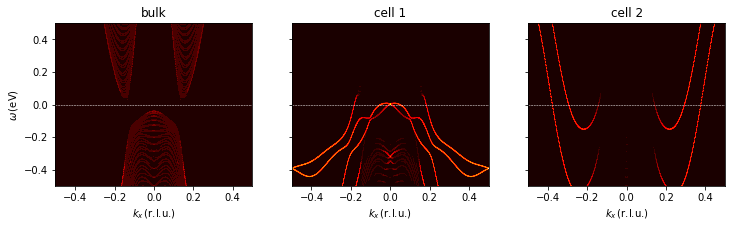

In [15]:
# plot the spectral function as a countour plot

fig, ax = plt.subplots(1,3,figsize=(4*3,3), sharey=True)
title_list = ["bulk", "cell 1", "cell 2"]

for iax, A, title_tmp in zip(ax, [A_bulk, A_celli, A_cellf], title_list):
    iax.contourf(ks[:,0], e_grid, A.T, levels=20, cmap='hot')
    iax.set_xlabel(r"$k_x\,$(r.l.u.)")
    iax.set_ylim(-0.5, 0.5)
    iax.set_title(title_tmp)
    iax.axhline(0.0,  color='w', linewidth=0.5, linestyle='--')

ax[0].set_ylabel(r"$\omega\,$(eV)")

fig.savefig(f"./figures/ribbon_efield{efield}_zoomin.png", dpi=480, bbox_inches='tight')

In [8]:
# now plot the density of states in the real space and frequency domain
# first set up the positions of the orbital centers in the real space
wpath = f"../tb_model/model_o{nwann}/"
xyz_file = f'{wpath}/wte2.o{nwann}_centres.xyz'
# read the coordinates
cart_coords = []
with open(xyz_file, 'r') as f:
    for line in f.readlines():
        if line.split()[0] == "X":
            cart_coords.append([float(item) for item in line.split()[1:]])
cart_coords = np.asarray(cart_coords)
# repeat them by the number of unit cells in the y direction
b_in_ang = 6.270725
# now set up the coordinates of the orbitals along the ribbon
cart_coords_all = cart_coords
for i in np.arange(1, ribbon_width):
    cart_coords_all = np.concatenate([cart_coords_all, cart_coords + np.array([0, i*b_in_ang, 0])], axis=0)


In [9]:
# read the final spread of the wannier functions
def read_spread(spread_file):
    spread = []
    with open(spread_file, 'r') as f:
        for line in f.readlines():
            spread.append(float(line.split()[-1]))
    return np.array(spread)

wfunc_spread = read_spread(f"{wpath}/final_spread.dat")
# repeat for width of the ribbon
wfunc_spread = np.concatenate([wfunc_spread]*ribbon_width)

In [10]:
def gaussian(x, mu, sigma):
    """
    Return a renormalized gaussian. 
    Input:
        x: the x values, (nx) array
        mu: the mean of the gaussian, (ncenter) array
        sigma: the standard deviation of the gaussian, (ncenter) array
    Output:
        (nx, ncenter) array
    """
    return np.exp(-0.5 * ((x[:,np.newaxis] - mu) / sigma)**2) / (np.sqrt(2*np.pi) * sigma)


In [11]:
def dos_k_r(omega_grid, y_grid, 
            eigvals, eigvecs, 
            cart_coords_all = cart_coords_all, wfunc_spread = wfunc_spread):
    '''
    Returns the DOS on an omega grid in the real space 
    DOS(omega, r) = \sum_{nk,i} |<nk|w_i><w_i|r>|^2 \delta(\omega-E_{nk}).
    We adapt the naive approximation that all the Wannier functions <r|w_i> are 
    like Gaussians with the spread given by wfunc_spread, centered at the cart_coords_all.
    (Not that we don't know how to do this more rigorously...but this is an okay starting point.)
    Input: 
        omega_grid: the grid of the frequency
        y_grid: real-space grid in the y direction
        eigvals: the eigenvalues at all k
        eigvecs: the eigenvectors at all k
        cart_coords_all: the cartesian coordinates of the orbitals
    '''
    dos = np.zeros([len(omega_grid), len(y_grid)], dtype=complex)
    
    # compute the lorentzian of all k
    # gaussian in y direction of all the orbitals
    g_y = gaussian(y_grid, cart_coords_all[:,1], wfunc_spread)


    for eigvals_k, eigvecs_k in zip(eigvals, eigvecs):  
        proj_k = np.einsum('in,in,ji->nj', eigvecs_k, eigvecs_k.conj(), g_y)
        dos += lorentzian(omega_grid, 0, eigvals_k, proj_k, broadening=1e-2)
    return dos

In [12]:
y_grid = np.linspace(0, b_in_ang*ribbon_width, 100)
dos = dos_k_r(e_grid, y_grid, eigvals_sel, eigvecs_sel)

In [13]:
# save dos to a hdf5 file
with h5py.File(f"./data/dos_efield{efield}.h5", 'w') as f:
    f.create_dataset("dos", data=dos)
    f.create_dataset("y_grid", data=y_grid)
    f.create_dataset("e_grid", data=e_grid) 

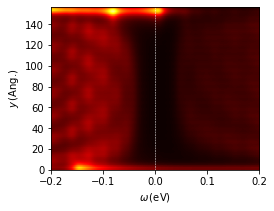

In [14]:
# Plot a heatmap of the real-space dos
fig, ax = plt.subplots(1,1,figsize=(20,3))
ax.imshow(dos.real.T, aspect=0.002, vmax=dos.real.max()/2, vmin=dos.real.min(),  
        extent=[e_grid.min(), e_grid.max(), y_grid.min(), y_grid.max()], cmap='hot')

ax.set_xlim([-0.2, 0.2])
ax.axvline(0, color='w', linestyle='--', lw=0.5)
ax.set_xlabel(r"$\omega\,$(eV)")
ax.set_ylabel(r"$y\,$(Ang.)")

fig.savefig(f"./figures/ribbon_dos_efield{efield}.png", dpi=480, bbox_inches='tight')